# Theoretical magnetic moment distribution

### Brief description

This Jupyter notebook is a supplementary material contaning the code needed to generate part of the synthetic data and reproduce part of the figures and results of this course. This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/index.html).

This code presents a numerical validation of the theoretical magnetic moment distribution within a planar equivalent layer.

**Note:** A Jupyter notebook is a document that incorporates text, results, figures, and the Python source code to produce them. If you are viewing this from the URL https://nbviewer.jupyter.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install all the required dependencies. For installing the Fatiando a Terra and all the required dependencies, please follow the instructions shown in http://www.fatiando.org/install.html.

### Import the required dependencies

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cPickle as pickle
import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af

from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang
from fatiando.constants import G, SI2MGAL

In [2]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

In [3]:
notebook_name = 'theoretical_moment.ipynb'

In [4]:
saved_files = [] #list of saved files

### Load the synthetic model formed by two rectangular prisms

In [5]:
with open('results\\model.pickle') as f:
        full_model = pickle.load(f)

In [6]:
inc, dec = full_model['geomag_field']

In [7]:
ints, incs, decs = vec2ang(full_model['model'][0].props['magnetization'])

In [8]:
rhos = full_model['model'][0].props['density']

In [9]:
with open('results\\model_pole.pickle') as f:
        full_model_pole = pickle.load(f)

### Load the grid of points

In [10]:
with open('results\\coarse_grid.pickle') as f:
        coarse_grid = pickle.load(f)

In [11]:
coarse_grid

{'DS': 113622.01742204267,
 'N': 8100,
 'area': [0, 30000, 5000, 35000],
 'metadata': 'Generated by computation_points.ipynb on 19 October 2016 19:29:39 UTC',
 'shape': (90, 90),
 'spacing': [337.07865168539325, 337.07865168539325]}

### Define the coordinates on the observation surface

In [12]:
#coordinates x and y of the data
xp, yp = regular(coarse_grid['area'], coarse_grid['shape'])

#vertical coordinates of the data
zp = af.observation_surface(xp,yp)

### Observed total-field anomaly

Noise-free total-field anomaly (equation 8) produced by the synthetic prisms (Figure 3) at the `coarse_grid` points on the undulating surface (Figure 4).

In [13]:
tf = prism.tf(xp,yp,zp,full_model['model'], inc, dec)

### True RTP anomaly

Noise-free RTP anomaly (equation 9) produced by the synthetic prisms (Figure 3) at the `coarse_grid` points on the undulating surface (Figure 4).

In [14]:
tf_pole = prism.tf(xp,yp,zp,full_model_pole['model'], 90., 0.)

### Planar equivalent layer

#### Parameters defining the equivalent layer

In [15]:
#horizontal plane containing the equivalent sources
z0 = np.zeros_like(zp)
#h = np.max(zp) + 1.4*dx
h = -200.
z0 += h

In [16]:
print h

-200.0


#### Theoretical magnetic moment distribution within the equivalent layer

In [17]:
#equivalent layer
layer = PointGrid(coarse_grid['area'], h, coarse_grid['shape'])

In [18]:
# gravity anomaly produced by the synthetic prisms at the planar equivalent layer
g0 = prism.gz(xp, yp, z0, full_model['model'])

In [19]:
caption = "Noise-free gravity anomaly (equation 1) produced by the synthetic prisms (Figure 3) \
at a $%d \\times %d$ grid of points located on the horizontal plane $z_{c} = %.1f$." \
% (coarse_grid['shape'][0], coarse_grid['shape'][1], h)

In [20]:
dp(md(caption))

Noise-free gravity anomaly (equation 1) produced by the synthetic prisms (Figure 3) at a $90 \times 90$ grid of points located on the horizontal plane $z_{c} = -200.0$.

In [21]:
# theoretical magnetic-moment distribution (equation 52)
moment = ints*g0*coarse_grid['DS']/(2.*np.pi*G*SI2MGAL*rhos)

In [22]:
# set the magnetic moment distribution within the planar equivalent layer
layer.addprop('magnetization', ang2vec(moment, incs, decs))

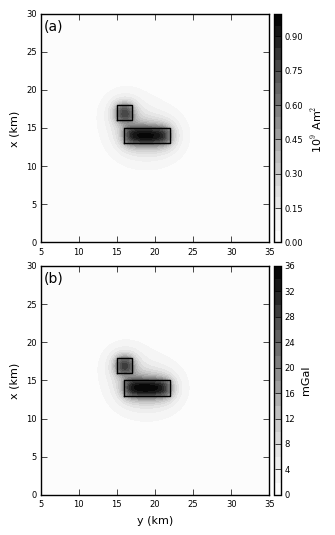

In [23]:
file_name = 'figs\\Fig6'

nplots = 2

f, (ax1, ax2) = plt.subplots(nplots,figsize=(3.33333,nplots*2.66667))

af.multiplotmap(ax2, xp, yp, g0, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys', prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], unit = 'mGal', 
                figure_label = '(b)')

af.multiplotmap(ax1, xp, yp, (10.**-9)*moment, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys', prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], unit = '10$^{9}$ Am$^{2}$', 
                ranges = (0., 1.),
                figure_label = '(a)', label_x = False)

plt.savefig(file_name+'.eps', dpi=600)
saved_files.append(file_name+'.eps')

plt.show()

In [24]:
caption = "(a) Theoretical magnetic-moment distribution \
(equation 56) calculated within a planar equivalent layer. \
The layer is formed by a regular grid of %d $\\times$ %d \
dipoles located at coordinates $(x_{j}, y_{j}, z_{c})$, \
$j = 1, \dots, N =$ %d, where $z_{c} =$ %.0f m. \
This magnetic-moment distribution is calculated by using (b) the \
noise-free gravity anomaly (equation 1), which is \
produced by the synthetic prisms (Figure 3) at the \
coordinates of the dipoles. \
The black rectangles represent the horizontal projection of the simulated prisms \
(Figure 3)." \
% (coarse_grid['shape'][0], coarse_grid['shape'][1], coarse_grid['N'], h)

In [25]:
dp(md(caption))

(a) Theoretical magnetic-moment distribution (equation 56) calculated within a planar equivalent layer. The layer is formed by a regular grid of 90 $\times$ 90 dipoles located at coordinates $(x_{j}, y_{j}, z_{c})$, $j = 1, \dots, N =$ 8100, where $z_{c} =$ -200 m. This magnetic-moment distribution is calculated by using (b) the noise-free gravity anomaly (equation 1), which is produced by the synthetic prisms (Figure 3) at the coordinates of the dipoles. The black rectangles represent the horizontal projection of the simulated prisms (Figure 3).

#### Save the theoretical magnetic moment distribution within the equivalent layer

In [26]:
theoretical_mag_dist = dict() #empty dictionary

In [27]:
#area over which the equivalent layer is defined
#x minimum, x maximum, y minimum and y maximum
theoretical_mag_dist['area'] = layer.area

#number of equivalent sources along the x and y directions
theoretical_mag_dist['shape'] = layer.shape

#constant depth zc
theoretical_mag_dist['zc'] = h

#magnetic-moment distribution
theoretical_mag_dist['moment'] = moment

In [28]:
#auxiliary informations about the theoretical magnetic-moment distribution
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
theoretical_mag_dist['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [29]:
#save the theoretical magnetic-moment distribution by using the Python 
#pickle module (https://docs.python.org/2/library/pickle.html)
file_name = 'results\\theoretical_mag_dist.pickle'
with open(file_name, 'w') as f:
    pickle.dump(theoretical_mag_dist, f)
saved_files.append(file_name)

#### Comparison by the magnetic data produced by the simulated prisms and those ones produced by the equivalent layer having the theoretical magnetic-moment distribution

In [30]:
# calculates the predicted total-field anomaly
tf_pred = sphere.tf(xp, yp, zp, layer, inc, dec)

In [31]:
# equivalent layer
layer_pole = PointGrid(coarse_grid['area'], h, coarse_grid['shape'])

In [32]:
# set the magnetic moment distribution within the planar equivalent layer
# for calculating the RTP anomaly
layer_pole.addprop('magnetization', ang2vec(moment, 90., 0.))

In [33]:
# predicted RTP anomaly
tf_pred_pole = sphere.tf(xp, yp, zp, layer_pole, 90., 0.)

In [34]:
# differences
print 'minimum, mean and maximum differences'
print 'Total-field anomalies:'
print '%.5f %.5f %.5f' % (np.min(tf_pred - tf), np.mean(tf_pred - tf), np.max(tf_pred - tf))
print 'RTP anomalies:'
print '%.5f %.5f %.5f' % (np.min(tf_pred_pole - tf_pole), np.mean(tf_pred_pole - tf_pole), np.max(tf_pred_pole - tf_pole))

minimum, mean and maximum differences
Total-field anomalies:
-5.01496 -0.27727 2.09757
RTP anomalies:
-0.07105 0.84949 5.60517


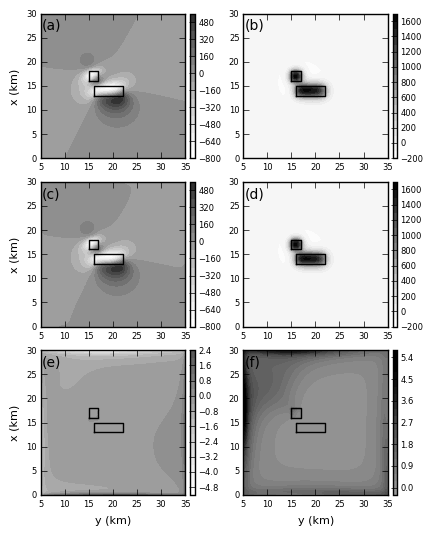

In [35]:
file_name = 'figs\\Fig5'

f, ax = plt.subplots(3,2,figsize=(4.33333,2*2.66667))

af.multiplotmap(ax[0][0], xp, yp, tf, coarse_grid['shape'], coarse_grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(tf, div=True),
                figure_label = '(a)', label_position = (0.02,0.89), label_x = False)

af.multiplotmap(ax[1][0], xp, yp, tf_pred, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = af.scale_bounds(tf, div=True),
                figure_label = '(c)', label_position = (0.02,0.89), label_x = False)

af.multiplotmap(ax[2][0], xp, yp, tf_pred - tf, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = (-5., 5.),
                figure_label = '(e)', label_position = (0.02,0.89))

af.multiplotmap(ax[0][1], xp, yp, tf_pole, coarse_grid['shape'], coarse_grid['area'], 
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model_pole['projection'],
                figure_label = '(b)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[1][1], xp, yp, tf_pred_pole, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], 
                figure_label = '(d)', label_position = (0.02,0.89), label_x = False, label_y = False)

af.multiplotmap(ax[2][1], xp, yp, tf_pred_pole - tf_pole, coarse_grid['shape'], coarse_grid['area'],
                color_scheme = 'Greys',
                prism_projection = True, projection_style = '-k', 
                model = full_model['projection'], ranges = (-5., 5.),
                figure_label = '(f)', label_position = (0.02,0.89), label_y = False)

plt.tight_layout()

plt.savefig(file_name+'.eps', dpi=600)
saved_files.append(file_name+'.eps')

plt.show()

In [36]:
caption = "(a) Noise-free total-field (equation 8) \
and (b) RTP (equation 9) anomalies \
produced by the synthetic prisms (Figure 3) on the \
undulating surface shown in Figure 4. \
(c) Total-field and (d) RTP anomalies produced by the planar \
equivalent layer which is defined in Figure 6. The \
magnetic moment distribution of this equivalent layer was directly \
calculated by equation 56 and is shown in Figure 6a. \
(e) Difference between the total-field anomalies shown in c and (a). \
(f) Difference between the RTP anomalies shown in d and b. \
These anomalies are calculated at a regular grid of %d $\\times$ %d points located on \
the observation surface (Figure 4). \
The black rectangles represent the horizontal projection of the simulated \
prisms (Figure 3). The field values are in nT." \
% (coarse_grid['shape'][0], coarse_grid['shape'][1])

In [37]:
dp(md(caption))

(a) Noise-free total-field (equation 8) and (b) RTP (equation 9) anomalies produced by the synthetic prisms (Figure 3) on the undulating surface shown in Figure 4. (c) Total-field and (d) RTP anomalies produced by the planar equivalent layer which is defined in Figure 6. The magnetic moment distribution of this equivalent layer was directly calculated by equation 56 and is shown in Figure 6a. (e) Difference between the total-field anomalies shown in c and (a). (f) Difference between the RTP anomalies shown in d and b. These anomalies are calculated at a regular grid of 90 $\times$ 90 points located on the observation surface (Figure 4). The black rectangles represent the horizontal projection of the simulated prisms (Figure 3). The field values are in nT.

### Saved files

In [38]:
with open('reports\\report_%s.md' % notebook_name[:st.index(notebook_name,'.')], 'w') as f:
    f.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    f.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        f.write('*  `%s` \n' % (sf))

1  figs\Fig6.eps
2  results\theoretical_mag_dist.pickle
3  figs\Fig5.eps
